# Introduction
This worksheet focuses on Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs). You will:

- Build and experiment with CNN architectures for image‑based tasks, learning how convolution, pooling, and feature extraction work in practice, and comparing your results with equivalent PyTorch implementations.

- Implement and train RNN‑based models- LSTMs, or GRUs—for sequence data, exploring how these networks capture temporal patterns and how different architectures affect performance.

# 0. Preliminaries
We firstly import the libraries required for this worksheet: NumPy for numerical computations, Matplotlib for plotting, and PyTorch for building and training models.

In [ ]:
##TODO

In [ ]:
import torchvision
import torchvision.transforms as transforms

# 1. Convolutional Neural Network (CNN)  
In this question, you will build and train a convolutional neural network using PyTorch to classify images from the CIFAR‑10 dataset.
CIFAR‑10 contains 60,000 colour images across 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.
Each image is a 3‑channel (RGB) image of size 32×32 pixels.

In this question, you will:  
(a) Load and normalize the CIFAR10 training and test datasets using `torchvision`  
(b) Implement a CNN in PyTorch (e.g., using `nn.Conv2d`, `nn.ReLU`, `nn.MaxPool2d`, and fully connected layers).  
Train your network on the CIFAR‑10 training set using a suitable loss function and optimizer.  
(c) Evaluate the performance of your model on the test set using appropriate metrics (e.g., accuracy, precision). Plot the confusion matrix to visualise the performance of your classifier.  
(d) Implement the transfer learning approach using a pretrained model and compare the model performances.

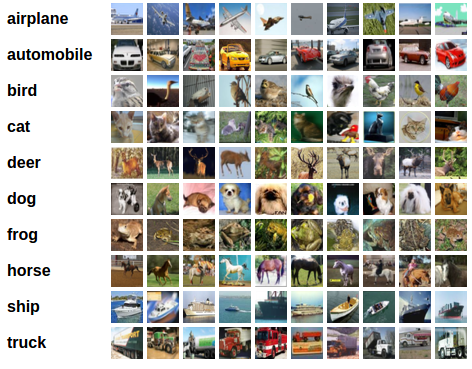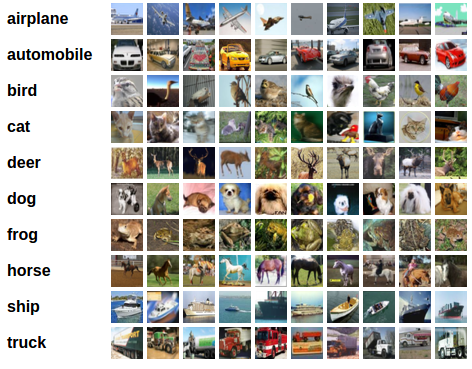

## Part (a)  
Load the CIFAR‑10 dataset using torchvision.datasets together with the given transformation. Use this transform when creating both the training and test sets.

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load CIFAR-10 training and test sets
batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_subset = torch.utils.data.Subset(trainset, range(8000))
test_subset  = torch.utils.data.Subset(testset,  range(2000))

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Inspect the dataset to understand its structure. Determine how many training images are contained in trainset.

Examine the shape of a single image by checking the .shape attribute of a batch from `trainloader` (e.g., by iterating once and printing the tensor shape).

Look at the target labels and confirm that CIFAR‑10 contains 10 object categories (plane, car, bird, cat, deer, dog, frog, horse, ship, truck).

In [ ]:
##TODO

## Part (b)
Implement a CNN in PyTorch (e.g., using `nn.Conv2d`, `nn.ReLU`, `nn.MaxPool2d`, and fully connected layers).    
Train your network on the CIFAR‑10 training set using a suitable loss function and optimizer.  

In [ ]:
class CNN_Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution + pooling layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),   # conv1
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(6, 16, kernel_size=5),  # conv2
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),  # fc1
            nn.ReLU(),
            nn.Linear(120, 84),         # fc2
            nn.ReLU(),
            nn.Linear(84, 10)           # fc3 (10 classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


Set up the CNN by specifying the parameters. Then create the model and prepare it for training by choosing an appropriate loss function (`CrossEntropyLoss` for multi‑class classification) and an optimizer (`Adam with a learning rate of 0.01).

In [ ]:
def train_model(model, train_loader, test_loader, epochs=20, lr=1e-3):
    criterion = ##TODO
    optimizer = ##TODO

    train_losses = []
    dev_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        dev_running = 0.0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                dev_loss = criterion(outputs, labels)
                dev_running += dev_loss.item()

        avg_dev_loss = dev_running / len(test_loader)
        dev_losses.append(avg_dev_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_dev_loss:.4f}")

    return train_losses, dev_losses


In [ ]:
model1 = ##TODO
_ = train_model(model1, trainloader, testloader, epochs=10, lr=1e-3)

Identify the epoch at which the validation loss stops decreasing.

## Part (c) 
Evaluate the performance of your model on the test set using appropriate metrics (e.g., accuracy, precision).  
Plot the confusion matrix to visualise the performance of your classifier.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
correct = 0
total = 0
all_preds = []
all_labels = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model1(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = #TODO

That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [ ]:
#TODO

## Part d
- Implement a transfer‑learning approach using a pretrained model from torchvision.models (e.g., ResNet50).
- Fine‑tune the model on CIFAR‑10.
- Compare its performance with your CNN.

In [ ]:
import torchvision.models as models

# --- Load pretrained ResNet50 ---
model2 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# --- Freeze all layers ---
for param in model2.parameters():
    param.requires_grad = False

# --- Replace final fully connected layer for CIFAR‑10 ---
num_features = model2.fc.in_features
model2.fc = nn.Linear(num_features, 10)

Train the ResNet model and identify the optimal number of epochs required for best performance.

In [ ]:
_ = train_model(model2, trainloader, testloader, epochs=5, lr=1e-3)

In [ ]:
Evaluate the performance of your model on the test set using appropriate metrics (e.g., accuracy, precision).  
Plot the confusion matrix to visualise the performance of your classifier.

In [ ]:
##TODO

Compare the performances of the two models. Modify the hyperparameters to improve the performance of both models.

# 2 Recurrent Neural Networks
In this section, we now build and compare two recurrent architectures: LSTM and GRU for time‑series forecasting using the Jena Climate dataset.
The goal is to predict future temperature values based on historical climate measurements.

In this task, you will:   
(a) Load & Visualise the Dataset (Jena Climate)  
(b) Split the dataset into training and test sets.
Convert both splits into PyTorch tensors or wrap them in TensorDataset + DataLoader.  
(c) Implement LSTM, and GRU Models.
Train each model for several epochs and record the training and validation losses.  
(d) Evaluate the Models  
(e) Visualise Results

# Part (a)  Load & Visualise the Dataset (Jena Climate)
- Download the data either manually from [Kaggle](https://www.kaggle.com/datasets/mnassrib/jena-climate) or by using the `kagglehub.dataset_download`  
- Load the CSV file  
- Read the climate data into a pandas DataFrame.  
- Convert "Date Time" into a proper datetime object and set it as the index.

In [ ]:
import kagglehub
import pandas as pd
import os

## Download dataset
path = kagglehub.dataset_download("mnassrib/jena-climate")
csv_path = os.path.join(path, "jena_climate_2009_2016.csv")
df = pd.read_csv(csv_path)

# Parse datetime column and set as index
df["Date Time"] = pd.to_datetime(df["Date Time"], format="%d.%m.%Y %H:%M:%S")
df = df.set_index("Date Time")
df.head()

The original Jena Climate dataset records measurements every 10 minutes. For many forecasting tasks, this resolution is unnecessarily fine and makes the dataset much larger than needed.  
Hence, we will downsample the data by taking every 6th row. which would give $6×10\text{ minutes}=60\text{ minutes}$  
Plot the hourly temperature series

In [ ]:
df = df.iloc[::6].copy()
# Plot
##TODO

# Part (b) Prepare Sequential Data for RNN Models
- Divide the data into 80/20\% split for training and testing while maintaining chronological order. 
- Apply Standard Scaling
- Convert the time‑series into supervised samples using a sliding window:
    Input: the previous lookback timesteps (5 days of history);
    Output: the target variable (the temperature "T (degC)") at the next timestep.
- Convert to PyTorch tensors and create DataLoaders.

Train / validation / test split (chronological)

Time-series samples are not i.i.d.; random splitting leaks “future” patterns into training and breaks the forecasting assumption.

In [ ]:
values = df.values.astype(np.float32)

n_total = int(len(values)*0.2)
n_train = int(0.80 * n_total)
n_test = n_total - n_train

train = values[:n_train]
test= values[n_train:n_total]

print("Total:", n_total)
print("Train:", train.shape, "Test:", test.shape)

RNNs train more effectively when inputs are normalised.  
We fit the scaler on the training portion only, then transform both train and test sets.

In [ ]:
from sklearn.preprocessing import StandardScaler
##TODO

### Sequence construction  

We predict temperature at time t using the previous 5 days (hourly): lookback = 24*5 = 120.

In [ ]:
def make_sequences(data, lookback, target_col):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, :])
        y.append(data[i, target_col])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
lookback = 24 * 5
target_col = df.columns.get_loc("T (degC)")

Xtr, Ytr = make_sequences(train_scaled, lookback, target_col)
Xte, Yte = make_sequences(test_scaled, lookback, target_col)

We need to convert our data into PyTorch‑compatible tensors so the model can train on it. PyTorch cannot operate directly on NumPy arrays — it requires tensors, which are optimized for automatic differentiation and efficient computation on both CPUs and GPUs.

In [ ]:
##TODO

We wrap the tensors in TensorDataset and DataLoader to enable efficient mini‑batch training.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
batch_size=64
# Create datasets
train_ds = TensorDataset(Xtr_t, Ytr_t)
test_ds   = TensorDataset(Xte_t, Yte_t)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader   = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# (c) Implement LSTM, and GRU Models

- Define a LSTM and GRU models. Use either `nn.LSTM` or `nn.GRU` to process sequential input and `nn.Linear` to map the final hidden state to a single regression output (next‑step temperature). Both models take input of shape:(batch, sequence length, features) and output a single temperature value for each sample.
- Train each model using `nn.CrossEntropyLoss()` and `optim.Adam()` for ~30 epochs:
- Track training and validation loss
- Plot training curves.

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)          # out: (batch, seq_len, hidden_dim)
        last = out[:, -1, :]          # last timestep: (batch, hidden_dim)
        y_hat = self.fc(last)         # (batch, 1)
        return y_hat


In [ ]:
class GRU_model(nn.Module):
##TODO

In [ ]:
def train_model(model, train_loader, test_loader, epochs=20, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # ---- TRAINING ----
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        val_running = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                val_pred = model(X_batch)
                val_loss = criterion(val_pred, y_batch)
                val_running += val_loss.item()

        avg_val_loss = val_running / len(test_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1:02d}: train={avg_train_loss:.6f}, val={avg_val_loss:.6f}")

    # ---- PLOT ----
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Training curves")
    plt.legend()
    plt.show()

    return train_losses, val_losses

In [ ]:
input_dim = Xtr_t.shape[2]

lstm = LSTM_model(input_dim=input_dim, hidden_dim=64)
_ = train_model(lstm, train_loader, test_loader, epochs=20, lr=1e-3)

In [ ]:
gru = GRU_model(input_dim=input_dim, hidden_dim=64)
_ = train_model(gru, train_loader, test_loader, epochs=20, lr=1e-3)

# (d) Evaluate the Models
For each model:

- Predict on test set  
- Invert scaling  
- Compute RMSE 

Because we used StandardScaler on all features, the target scaling is:  
$y_\text{scaled} = \frac{y - \mu}{\sigma}\Rightarrow y = y_\text{scaled}\sigma + \mu$

So we can invert temperature using `scaler.mean_[target_col]` and `scaler.scale_[target_col]`.

In [ ]:
from sklearn.metrics import mean_squared_error
target_mean = scaler.mean_[target_col]
target_std = scaler.scale_[target_col]

def inverse_temp(y_scaled):
    return y_scaled * target_std + target_mean

def rmse(a, b):
    return ##TODO

def evaluate_model(model, X, Y, name="Model"):
    model.eval()
    with torch.no_grad():
        yhat_scaled = model(X).detach().numpy().reshape(-1)
        y_scaled = Y.detach().numpy().reshape(-1)

    yhat = inverse_temp(yhat_scaled)
    ytrue = inverse_temp(y_scaled)
    
    score = rmse(ytrue, yhat)
    print(f"{name} Test RMSE: {score:.3f} °C")
    return ytrue, yhat, score

ytrue_lstm, yhat_lstm, rmse_lstm = evaluate_model(lstm, Xte_t, Yte_t, name="LSTM")
ytrue_gru, yhat_gru, rmse_gru = evaluate_model(gru, Xte_t, Yte_t, name="GRU")

## Part (e) Visualise Results

Predicted vs actual temperature curves


In [ ]:
#TODO

Which converged faster? 
Which generalised better? What will you modify to improve the performance of the models?